<a href="https://colab.research.google.com/github/Dinesh-Adhithya-H/Deep_Learning_using_Tensorflow/blob/main/C3_3_Embeddings_on_sarcasm_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
vocab_size=10000
embedding_dim=16
max_length=100
truc_type="post"
padding_type="post"
oov_tok="<OOV>"
training_size=2000

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-01-10 09:22:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.06s   

2021-01-10 09:22:54 (90.5 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [5]:
with open("/tmp/sarcasm.json","r") as f:
  data=json.load(f)

In [20]:
sentences=[]
labels=[]
for i in data:
  sentences.append(i["headline"])
  labels.append(i["is_sarcastic"])

In [31]:
training_sentences=sentences[0:training_size]
testing_sentences=sentences[training_size:]
training_labels=labels[0:training_size]
testing_labels=labels[training_size:]

In [32]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index=tokenizer.word_index

training_sequences=tokenizer.texts_to_sequences(training_sentences)
training_pad=pad_sequences(training_sequences,maxlen=max_length,padding=padding_type,truncating=truc_type)

testing_sequences=tokenizer.texts_to_sequences(testing_sentences)
testing_pad=pad_sequences(testing_sequences,maxlen=max_length,padding=padding_type,truncating=truc_type)

In [33]:
import numpy as np
training_pad=np.array(training_pad)
training_labels=np.array(training_labels)
testing_pad=np.array(testing_pad)
testing_labels=np.array(testing_labels)

In [34]:
model=tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(512,activation="relu"),                        
  tf.keras.layers.Dense(1,activation="relu")
])

In [35]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics="accuracy")

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               8704      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 169,217
Trainable params: 169,217
Non-trainable params: 0
_________________________________________________________________


In [37]:
history=model.fit(training_pad,training_labels,epochs=5,validation_data=(testing_pad,testing_labels))

Epoch 1/5
63/63 [==============================] - 5s 38ms/step - loss: 1.1106 - accuracy: 0.5508 - val_loss: 0.6842 - val_accuracy: 0.5613
Epoch 2/5
63/63 [==============================] - 2s 36ms/step - loss: 0.6795 - accuracy: 0.5647 - val_loss: 0.6802 - val_accuracy: 0.5613
Epoch 3/5
63/63 [==============================] - 2s 36ms/step - loss: 0.6753 - accuracy: 0.5497 - val_loss: 0.6744 - val_accuracy: 0.5613
Epoch 4/5
63/63 [==============================] - 2s 36ms/step - loss: 0.6587 - accuracy: 0.5882 - val_loss: 0.6654 - val_accuracy: 0.5613
Epoch 5/5
63/63 [==============================] - 2s 35ms/step - loss: 0.6467 - accuracy: 0.6063 - val_loss: 0.6466 - val_accuracy: 0.5621


In [38]:
import matplotlib.pyplot as plt
def plot_graphs(history,string):
  plt.plot(history.history[string])
  plt.plot(history.history["val_"+string])
  plt.xlabel("epochs")
  plt.ylabel(string)
  plt.legend([string,"val_"+string])
  plt.show()

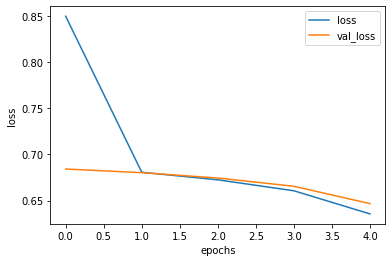

In [39]:
plot_graphs(history,"loss")

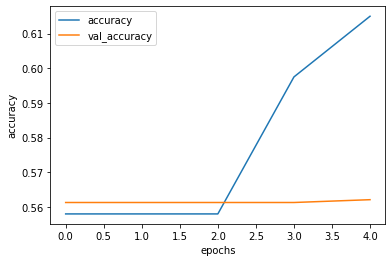

In [41]:
plot_graphs(history,"accuracy")

In [51]:
reverse_word_index=dict([(v,k) for (k,v) in word_index.items()])

In [52]:
def decode_sequence(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [56]:
decode_sequence([45,56,44])

'day now who'

In [57]:
print(decode_sequence(training_pad[0]))

former versace store clerk sues over secret 'black code' for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?


In [59]:
print(training_sentences[0])

former versace store clerk sues over secret 'black code' for minority shoppers


In [60]:
labels[0]

0

In [61]:
e=model.layers[0]
weights=e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [71]:
import io

out_v=io.open("vecs.tsv","w",encoding="utf-8")
out_m=io.open("meta.tsv","w",encoding="utf-8")
for word_num in range(1,6854):
  word=reverse_word_index[word_num]
  embeddings=weights[word_num]
  out_m.write(word+"\n")
  out_v.write("\t".join([str(x) for x in embeddings])+"\n")
out_m.close()
out_v.close()

In [72]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>